In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nbimporter   # pip install nbimporter
from fuzzificationCreditscore import get_fuzzy_sets, calculate_categorical_result, calculate_fuzzy_approval_status

import sys
print('System version',sys.version)

System version 3.8.19 (default, Mar 20 2024, 15:27:52) 
[Clang 14.0.6 ]


In [9]:
with open('dataset/filtered_df.pkl', 'rb') as f:
    df = pickle.load(f)  
df

,Employment_Status,Annual_Income,Credit_Score,Outstanding_Debt,Loan_Amount_Requested,Loan_Type,Loan_Approval_Status
0,Employed,139901,743,19822,24535,Secured,1
1,Employed,21162,468,18321,8288,Unsecured,0
4,Employed,81753,752,8780,23360,Unsecured,1
8,Self-Employed,121626,803,13940,20239,Secured,0
10,Self-Employed,54670,772,22104,20000,Unsecured,1
...,...,...,...,...,...,...,...
51986,Self-Employed,105630,734,14841,26616,Unsecured,1
51989,Unemployed,118085,714,9803,30183,Secured,0
51990,Self-Employed,134581,756,15172,24717,Unsecured,1
51992,Unemployed,34019,572,19031,8383,Unsecured,0


In [10]:
# Calculate averages manually for each Employment Status
employment_statuses = ["Self-Employed", "Unemployed", "Employed"]
averages = {}

for status in employment_statuses:
    subset = df[df["Employment_Status"] == status]
    averages[status] = {
        "Annual_Income": subset["Annual_Income"].mean(),
        "Credit_Score": subset["Credit_Score"].mean(),
        "Outstanding_Debt": subset["Outstanding_Debt"].mean(),
        "Loan_Amount_Requested": subset["Loan_Amount_Requested"].mean(),
        "Loan_Approval_Status": subset["Loan_Approval_Status"].mean(),
    }

# Print the results
for status, metrics in averages.items():
    print(f"Average metrics for {status}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")
    print()

Average metrics for Self-Employed:
  Annual_Income: 84185.91
  Credit_Score: 680.25
  Outstanding_Debt: 14839.15
  Loan_Amount_Requested: 21226.48
  Loan_Approval_Status: 0.65

Average metrics for Unemployed:
  Annual_Income: 83925.89
  Credit_Score: 678.40
  Outstanding_Debt: 15028.39
  Loan_Amount_Requested: 21135.45
  Loan_Approval_Status: 0.63

Average metrics for Employed:
  Annual_Income: 83358.82
  Credit_Score: 676.35
  Outstanding_Debt: 15068.12
  Loan_Amount_Requested: 21057.32
  Loan_Approval_Status: 0.64



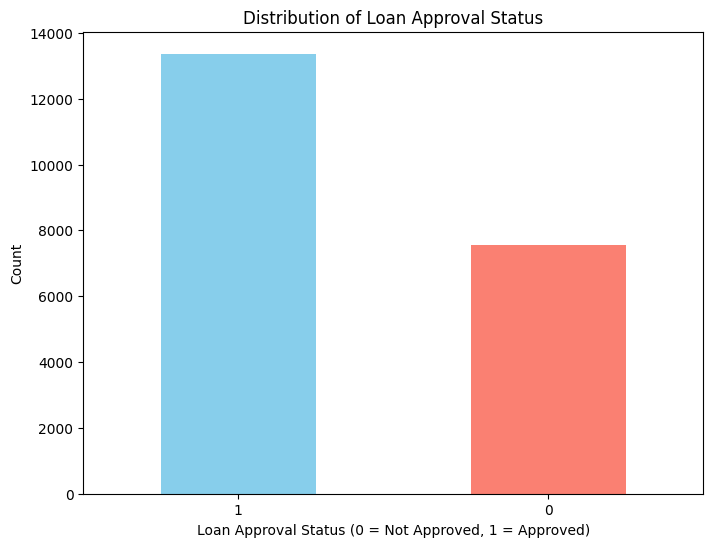

In [11]:
# Plotting the counts of loan approval statuses
loan_approval_counts = df['Loan_Approval_Status'].value_counts()
plt.figure(figsize=(8, 6))
loan_approval_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Loan Approval Status')
plt.xlabel('Loan Approval Status (0 = Not Approved, 1 = Approved)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

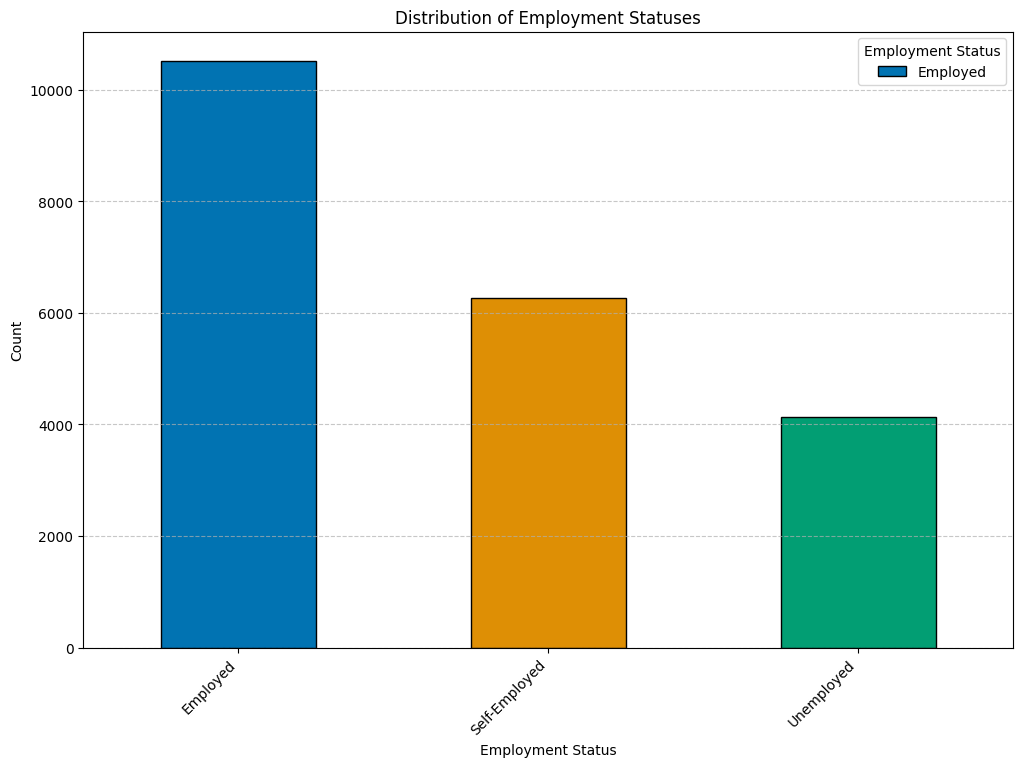

/var/folders/xq/6bpk1xjx63zdsznjsn67t60r0000gn/T/ipykernel_64993/345906494.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Employment_Status", y="Annual_Income", data=df, palette=colors)


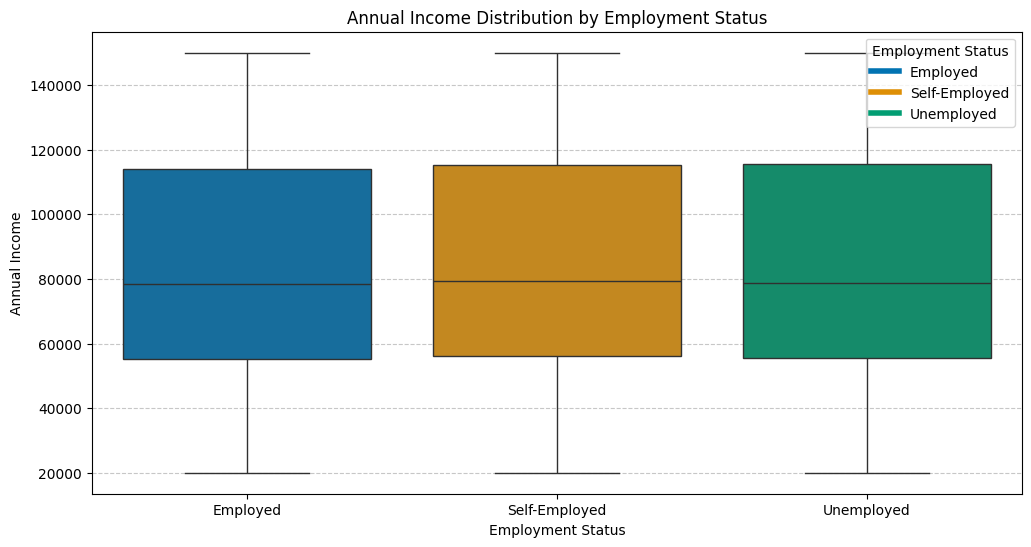

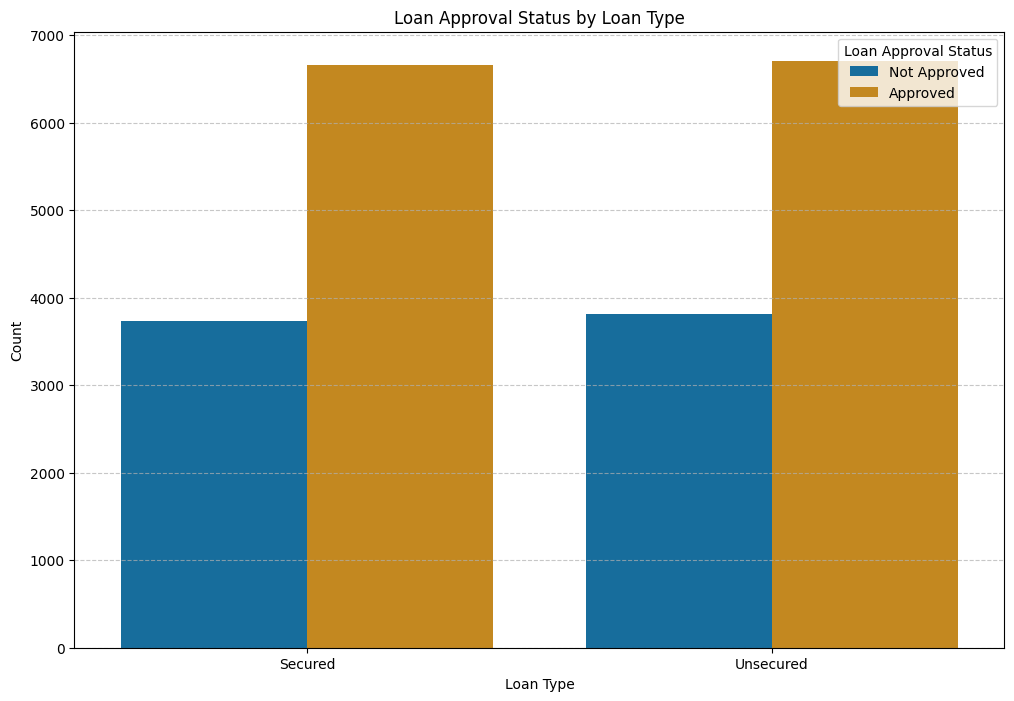

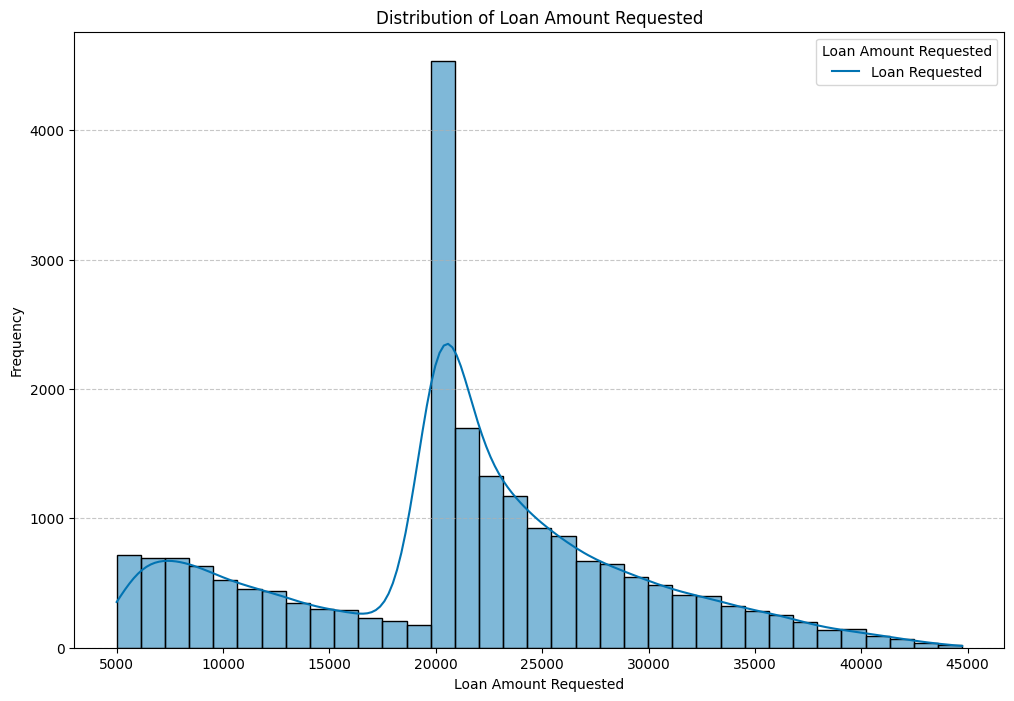

In [12]:
# Set seaborn colorblind palette
sns.set_palette("colorblind")

# Plot 1: Distribution of Employment Statuses with rotated x labels using colorblind palette for each status
plt.figure(figsize=(12, 8))
colors = sns.color_palette("colorblind", n_colors=len(df["Employment_Status"].unique()))
ax = df["Employment_Status"].value_counts().plot(kind="bar", color=colors, edgecolor="black")
plt.title("Distribution of Employment Statuses")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Employment Status", labels=df["Employment_Status"].unique())
plt.show()

# Plot 2: Boxplot for Annual Income by Employment Status with manually set colors and correct legend
plt.figure(figsize=(12, 6))

# Manually set the color for each Employment Status (3 colors)
colors = sns.color_palette("colorblind", n_colors=3)

# Create the boxplot without the legend
ax = sns.boxplot(x="Employment_Status", y="Annual_Income", data=df, palette=colors)

# Set title and labels
plt.title("Annual Income Distribution by Employment Status")
plt.xlabel("Employment Status")
plt.ylabel("Annual Income")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Manually creating the legend to match colors
handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(3)]
plt.legend(handles, df["Employment_Status"].unique(), title="Employment Status", loc="upper right")

# Show the plot
plt.show()

# Plot 3: Count plot for Loan Approval Status by Loan Type
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="Loan_Type", hue="Loan_Approval_Status", data=df, palette="colorblind")
plt.title("Loan Approval Status by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Count")
plt.legend(title="Loan Approval Status", loc="upper right", labels=["Not Approved", "Approved"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot 4: Distribution of Loan Amount Requested
plt.figure(figsize=(12, 8))
sns.histplot(df["Loan_Amount_Requested"], bins=35, kde=True, color=sns.color_palette("colorblind")[0], edgecolor="black")
plt.title("Distribution of Loan Amount Requested")
plt.xlabel("Loan Amount Requested")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Loan Amount Requested", labels=["Loan Requested"])
plt.show()

/Users/brageramberg/opt/miniconda3/envs/INF264/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


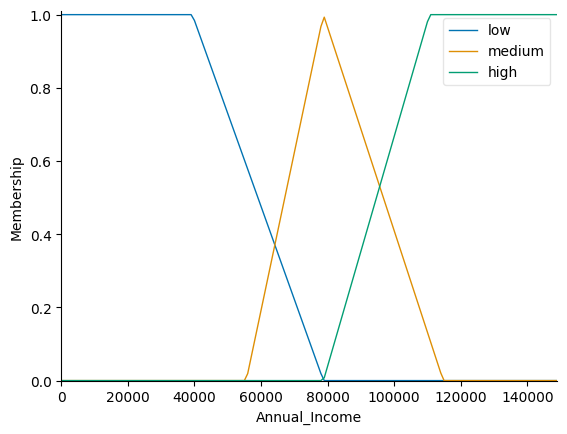

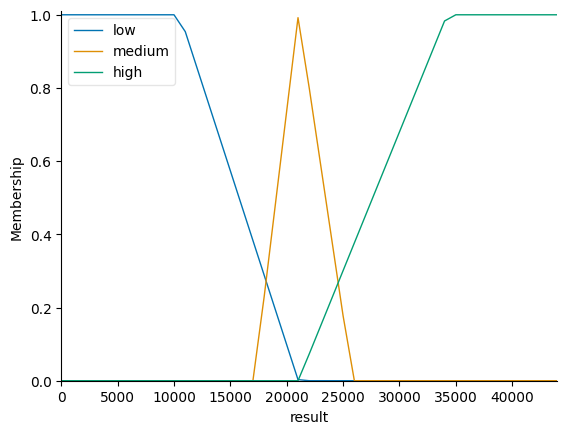

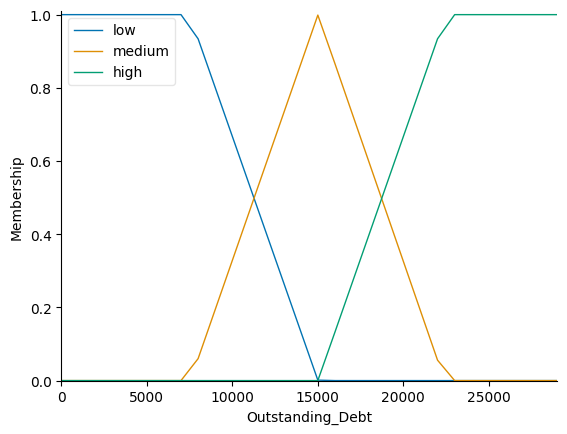

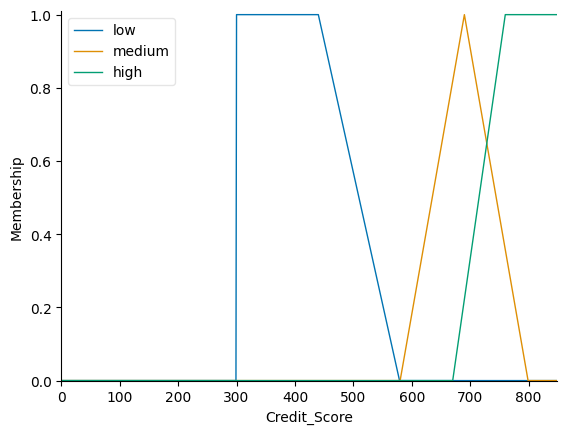

In [13]:
# Using inmported fuzzyfication functions to create columns for comparison
df[['Fuzzy_Request', 'Fuzzy_Loan_Eligibility']] = df.apply(
    lambda row: pd.Series(calculate_categorical_result(
        row, annual_income, outstanding_debt, credit_score, loan_amount_requested)), axis=1
)
df['Fuzzy_Approval_Status'] = df.apply(calculate_fuzzy_approval_status, axis=1)

annual_income.view()
loan_amount_requested.view()
outstanding_debt.view()
credit_score.view()

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.71      0.66      7554
           1       0.82      0.75      0.79     13365

    accuracy                           0.74     20919
   macro avg       0.72      0.73      0.72     20919
weighted avg       0.75      0.74      0.74     20919



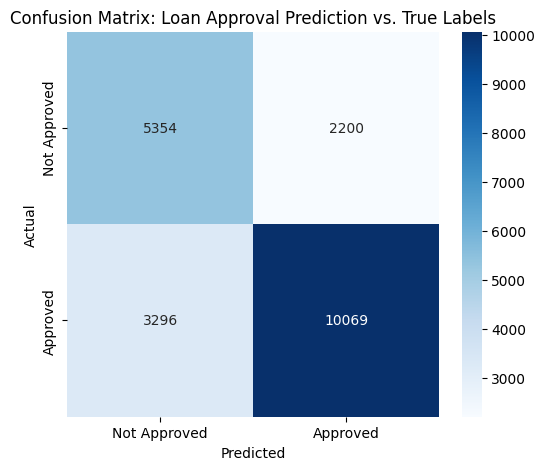

Accuracy: 73.73%


In [14]:
def compare_results(approval_status, true_labels):
    """
    Compares the fuzzy system's loan approval predictions with the actual true labels.
    
    Parameters:
    - approval_status: List of predicted loan approval statuses (Approved/Not Approved).
    - true_labels: List of true loan approval labels (Approved/Not Approved).
    
    Returns:
    - None: Displays accuracy and confusion matrix.
    """
    # Calculate the accuracy
    accuracy = accuracy_score(true_labels, approval_status)
    
    # Generate the confusion matrix with numeric labels
    cm = confusion_matrix(true_labels, approval_status)
    
    # Display the classification report
    print("Classification Report:\n", classification_report(true_labels, approval_status))
    
    # Plot Confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Approved", "Approved"], yticklabels=["Not Approved", "Approved"])
    plt.title("Confusion Matrix: Loan Approval Prediction vs. True Labels")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Display accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Get the fuzzy sets from your fuzzification process (as done in your fuzzification file)
annual_income, loan_amount_requested, outstanding_debt, credit_score = get_fuzzy_sets(df)



compare_results(df['Fuzzy_Approval_Status'], df['Loan_Approval_Status'])